# tensorboard使用-例子1
参考：[tensorboard](https://pytorch.apachecn.org/docs/1.4/6.html)

## 数据与模型

In [5]:
%matplotlib inline

In [30]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('../../../../../learnMLData/data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('../../../../../learnMLData/data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 启动tensorboard

In [34]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('../../../../../learnMLData/runs/fashion_mnist_experiment_1')

## 添加图片（add_image）

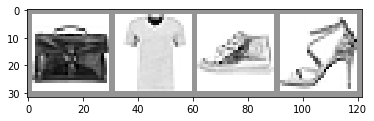

In [35]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

## 添加模型图（add_graph）

In [36]:
writer.add_graph(net, images)
writer.close()

## 添加一个“投影仪”（add_embedding）
通过 add_embedding 方法可视化高维数据的低维表示

In [37]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

## 模型跟踪
在前面的示例中，我们仅每 2000 次迭代打印该模型的运行损失。 现在，我们将运行损失记录到 TensorBoard 中，并通过plot_classes_preds函数查看模型所做的预测。

In [38]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

最后，让我们使用与之前教程相同的模型训练代码来训练模型，但是每 1000 批将结果写入 TensorBoard，而不是打印到控制台。 这是通过 add_scalar 函数完成的。

此外，在训练过程中，我们将生成一幅图像，显示该批次中包含的四幅图像的模型预测与实际结果。

### add_figure(准确率)

In [39]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


见IMAGE页面，tag为`predictions vs. actuals`，可以看到每个step时的数据。

## 评估模型
### PR图（add_pr_curve）

In [40]:
# 1\. gets the probability predictions in a test_size x num_classes Tensor
# 2\. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)
    
writer.close()

# 例子2
pytorch doc:[tensorboard](https://pytorch.org/docs/stable/tensorboard.html)

In [47]:
from torchvision import datasets

In [50]:
writer = SummaryWriter('../../../../../learnMLData/runs/tensorboard_test_1')

In [51]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('../../../../../learnMLData/data/mnist_train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [52]:
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
#writer.close()

## add_scalar():添加标量
### 数据分组
如每次添加loss，迭代次数等

In [54]:
for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

### 一个图添加多个数据

In [55]:
r = 5
for i in range(100):
    writer.add_scalars('run_14h', {'xsinx':i*np.sin(i/r),
                                    'xcosx':i*np.cos(i/r),
                                    'tanx': np.tan(i/r)}, i)

## add_histogram直方图

In [57]:
# 添加10个直方图
for i in range(10):
    x = np.random.random(1000)
    writer.add_histogram('distribution centers', x + i, i)

## add_image与add_images
### add_image
注意数据格式

In [59]:
img = np.zeros((3, 100, 100))
img[0] = np.arange(0, 10000).reshape(100, 100) / 10000
img[1] = 1 - np.arange(0, 10000).reshape(100, 100) / 10000

img_HWC = np.zeros((100, 100, 3))
img_HWC[:, :, 0] = np.arange(0, 10000).reshape(100, 100) / 10000
img_HWC[:, :, 1] = 1 - np.arange(0, 10000).reshape(100, 100) / 10000

writer.add_image('my_image', img, 0)

# If you have non-default dimension setting, set the dataformats argument.
writer.add_image('my_image_HWC', img_HWC, 0, dataformats='HWC')

### add_images
依赖：pillow包

In [60]:
img_batch = np.zeros((16, 3, 100, 100))
for i in range(16):
    img_batch[i, 0] = np.arange(0, 10000).reshape(100, 100) / 10000 / 16 * i
    img_batch[i, 1] = (1 - np.arange(0, 10000).reshape(100, 100) / 10000) / 16 * i
writer.add_images('my_image_batch', img_batch, 0)

## add_custom_scalars

In [62]:
layout = {'Taiwan':{'twse':['Multiline',['twse/0050', 'twse/2330']]},
             'USA':{ 'dow':['Margin',   ['dow/aaa', 'dow/bbb', 'dow/ccc']],
                  'nasdaq':['Margin',   ['nasdaq/aaa', 'nasdaq/bbb', 'nasdaq/ccc']]}}

writer.add_custom_scalars(layout)

## add_mesh：3D数据添加tensorboard

更多高级用法：https://threejs.org/docs/index.html#manual/en/introduction/Creating-a-scene

In [63]:
vertices_tensor = torch.as_tensor([
    [1, 1, 1],
    [-1, -1, 1],
    [1, -1, -1],
    [-1, 1, -1],
], dtype=torch.float).unsqueeze(0)
colors_tensor = torch.as_tensor([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [255, 0, 255],
], dtype=torch.int).unsqueeze(0)
faces_tensor = torch.as_tensor([
    [0, 2, 3],
    [0, 3, 1],
    [0, 1, 2],
    [1, 3, 2],
], dtype=torch.int).unsqueeze(0)

writer.add_mesh('my_mesh', vertices=vertices_tensor, colors=colors_tensor, faces=faces_tensor)

## add_hparams添加表格

In [64]:
for i in range(5):
        writer.add_hparams({'lr': 0.1*i, 'bsize': i},
                      {'hparam/accuracy': 10*i, 'hparam/loss': 10*i})

In [ ]:
writer.close()